In [7]:
import math
from operator import itemgetter
import numpy as np
from matplotlib import pyplot as plt
import cv2

def calculateDistance(x1,y1,x2,y2):
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

def rotateImage(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

def rectsFilter(arr, pos, length):
    v = []
    for i, a in enumerate(arr):
        if len(v) == length:
            break
        if len(v) > 0:
            if a[pos]-5 <= v[0][pos] <= a[pos]+5:
                a_size = a[2] + a[3]
                v_size = v[0][2] + v[0][3]
                if a_size-5 <= v_size <= a_size+5:
                    v.append(a)
            else:
                del v[:]
                v.append(a)
        else:
            v.append(a)
    return v
    

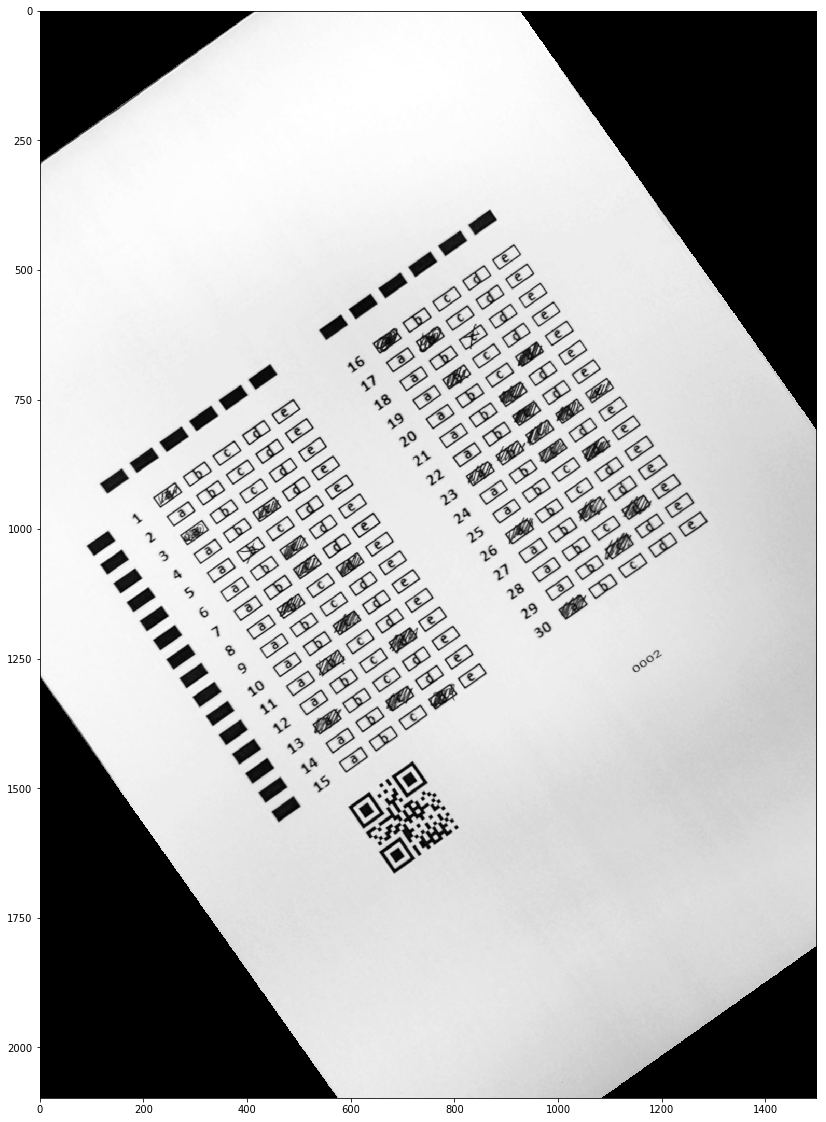

In [8]:
img  = cv2.imread('data/pattern_0002_scan_rotate.png')

plt.rcParams['figure.figsize'] = [30, 20]
plt.imshow(img)
plt.show()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)[1]

edges = cv2.Canny(thresh, 0.1, 1)

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 150  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 50  # maximum gap in pixels between connectable line segments
#line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of   detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

for line in lines:
    angle_radians = math.atan2(lines[1][0][3]-lines[1][0][1], lines[1][0][2]-lines[1][0][0])
    angle_degrees = angle_radians * (180.0/math.pi)

    thresh = rotateImage(thresh, angle_degrees)
    img = rotateImage(img, angle_degrees)
    break

corners = cv2.goodFeaturesToTrack(thresh,
        maxCorners=1000,
        qualityLevel=0.02,
        minDistance=15.0,
        useHarrisDetector=False,
)
corners = np.int0(corners)

(_,contours,_) = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

threshold = 4
rects = []
for contour in contours:
    (x, y, w, h) = cv2.boundingRect(contour)
    rects.append([x, y, w, h])

# order by X 
rects = sorted(rects, key=itemgetter(0))
# filter 15 rects by X
lines = rectsFilter(rects, 0, 15)

# order by Y
rects = sorted(rects, key=itemgetter(1))
# filter 12 rects by Y
columns = rectsFilter(rects, 1, 12)

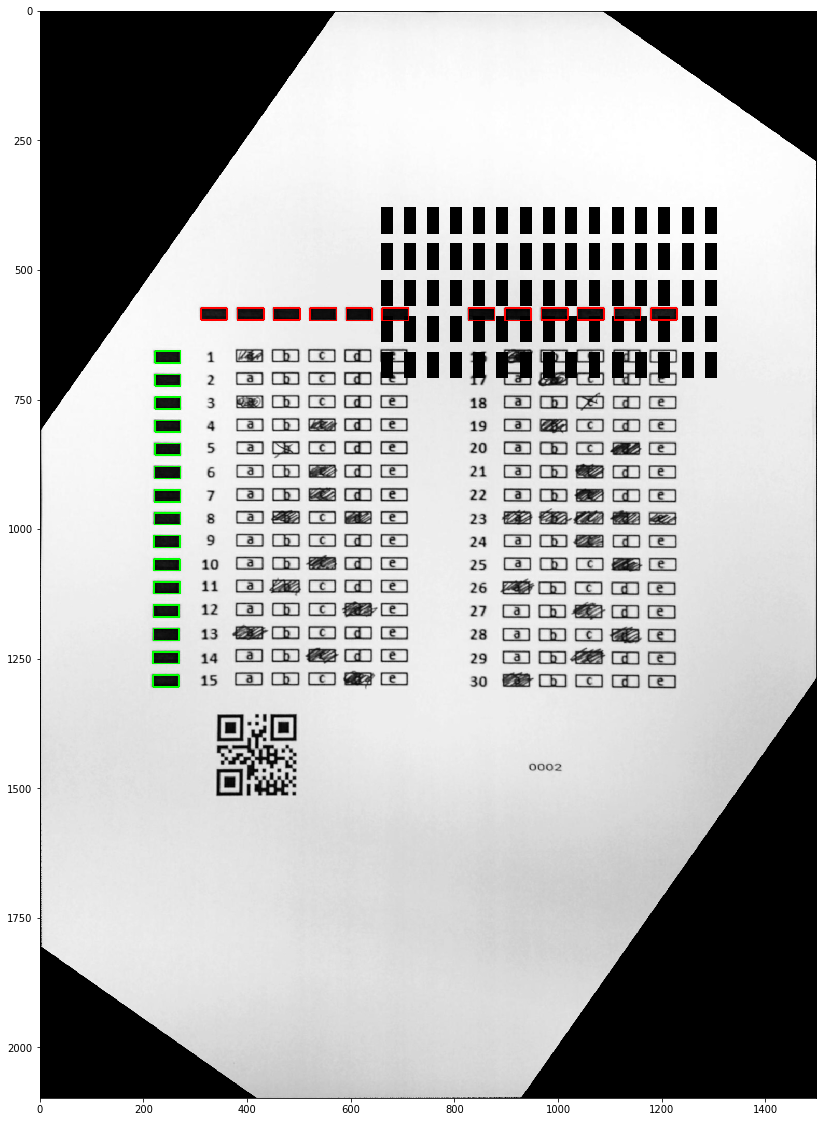

In [44]:
plt.rcParams['figure.figsize'] = [30, 20]

for v in lines:
    cv2.rectangle(img, (v[0], v[1]), (v[0]+v[2], v[1]+v[3]), (0, 255, 0), 2)
for h in columns:
    cv2.rectangle(img, (h[0], h[1]), (h[0]+h[2], h[1]+h[3]), (255, 0, 0), 2)
plt.imshow(img)
plt.show()

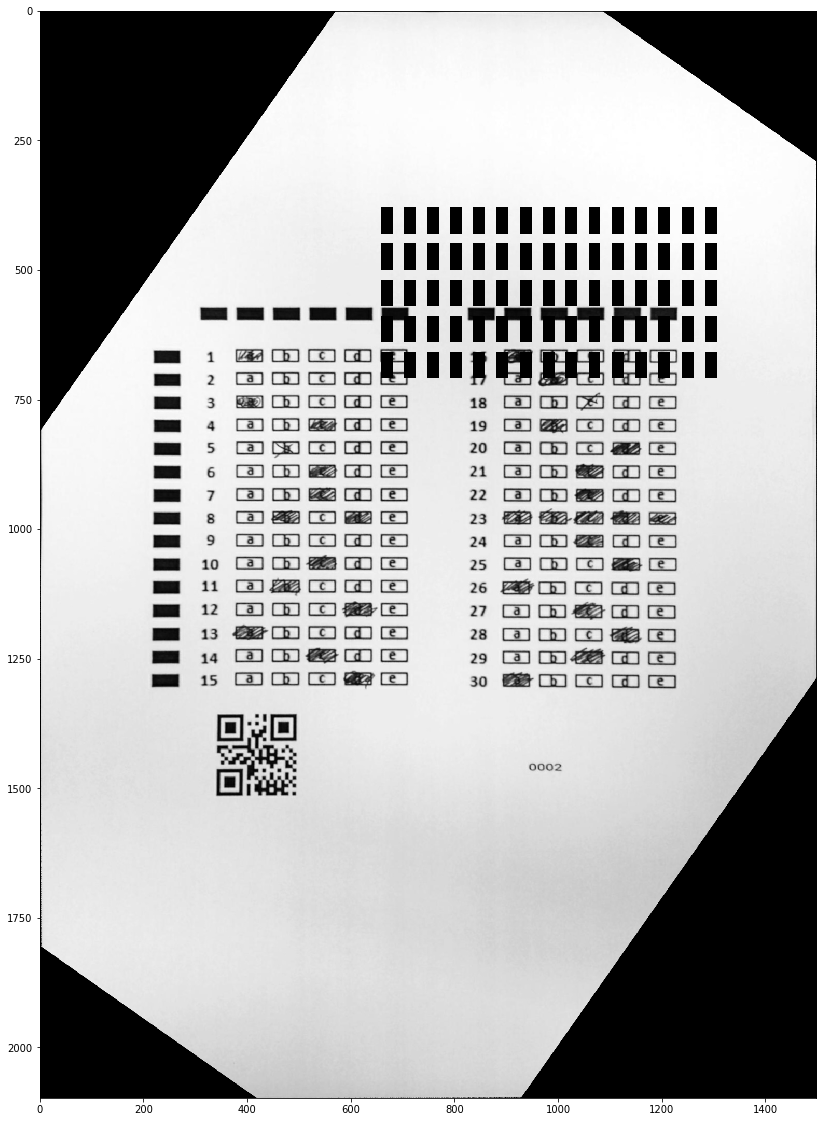

In [43]:
plt.rcParams['figure.figsize'] = [30, 20]
plt.imshow(img)
plt.show()

In [42]:
#ret, img2 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

print(lines)
print(columns)

for i in range(15):
    for j in range(1, 6):
        x_init = columns[j][0]
        x_end = x_init + columns[j][2]
        y_init = lines[i][1]
        y_end = y_init + lines[i][3]
        
        img[x_init:x_end,y_init:y_end] = 0
        #answer_block = img2[x_init:x_end,y_init:y_end]
        #answer_block = answer_block[:,:,0]
        
        print( answer_block.sum() / (255 * len(answer_block)))
        #print(answer_block.shape)
        #print(answer_block.sum())
        #print(answer_block)
        
        total_black = 0
        total_white = 0
        
        
        
#         for x in range(columns[j][0], columns[j][0] + columns[j][2]):
#             for y in range(lines[i][1], lines[i][1] + lines[i][3]):
#                 if img2[x][y][0] == 255:
#                     total_white += 1
#                 else:
#                     total_black += 1
#         print("white" + str(total_white))
#         print("black" + str(total_black))

[[217, 1282, 50, 23], [217, 1237, 51, 23], [218, 1192, 50, 23], [218, 1147, 50, 23], [219, 1102, 50, 23], [219, 1058, 50, 22], [219, 1013, 50, 23], [220, 969, 50, 23], [220, 925, 50, 23], [220, 880, 50, 23], [221, 835, 49, 23], [221, 791, 49, 22], [221, 746, 49, 23], [221, 702, 49, 23], [221, 657, 49, 23]]
[[310, 574, 50, 23], [380, 574, 51, 23], [450, 574, 51, 23], [520, 574, 51, 24], [590, 574, 50, 24], [659, 574, 51, 24], [826, 574, 50, 24], [896, 574, 50, 24], [966, 574, 51, 23], [1036, 574, 51, 23], [1107, 574, 50, 23], [1178, 574, 50, 23]]
17.098039215686274
17.098039215686274
17.098039215686274
17.098039215686274
17.098039215686274
17.098039215686274
17.098039215686274
17.098039215686274
17.098039215686274
17.098039215686274
17.098039215686274
17.098039215686274
17.098039215686274
17.098039215686274
17.098039215686274
17.098039215686274
17.098039215686274
17.098039215686274
17.098039215686274
17.098039215686274
17.098039215686274
17.098039215686274
17.098039215686274
17.09803921

In [25]:
299115 == 51*23*255

True